# ボルツマン機械学習にD-Waveマシンを用いる(実践編part1)

## 概要

本記事は、以下の論文の再現実験を行ったものです。具体的には、D-Waveマシンを用いた手書き数字の生成・復元を行います。

この論文に関する詳しい解説は、記事「[ボルツマン機械学習にD-Waveマシンを用いる](https://qard.is.tohoku.ac.jp/T-Wave/)」をご覧ください。

## 文献情報

* タイトル：Quantum-Assisted Learning of Hardware-Embedded Probabilistic Graphical Models
* 著者：Marcello Benedetti, John Realpe-Gómez, Rupak Biswas and Alejandro Perdomo-Ortiz
* 書誌情報：Phys. Rev. X 7, 041052 (2017)
* DOI : [10.1103/PhysRevX.7.041052](https://link.aps.org/doi/10.1103/PhysRevX.7.041052)

## 問題

実験の全体像は次の通りです。

![実験の概要](https://journals.aps.org/prx/article/10.1103/PhysRevX.7.041052/figures/1/medium)

(a)では、ボルツマン機械学習による画像生成を行います。

(b)では、学習済みのパラメータ($J$, $h$)から画像の復元を行います。

## 実験

まず、ボルツマン機械学習による画像生成を行います。

### ライブラリのインストール

ここで、必要なライブラリをインストールします。

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install dwave-ocean-sdk
!pip install openjij
!pip install tqdm

### データセットの準備

学習に用いるデータセット(手書き数字)は、scikit-learnから利用できるMNISTを用います。

In [ ]:
from sklearn.datasets import load_digits

# 手書き数字を取得
digits = load_digits()

データセットには0-9の数字が含まれていますが、今回は「0」を学習に用いることにします。

使用する「0」のデータセットを表示してみましょう。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show_img(row, col, img_list1, img_list2, title_list1, title_list2, subtitle, subtitlesize, figsize):
    fig, ax = plt.subplots(row, col, figsize=figsize)
    fig.suptitle(subtitle, fontsize=subtitlesize, color='black')

    for i in range(col):
        if row == 1:
            img1 = np.reshape(img_list1[i], (8, 8))
            ax[i].imshow(img1, cmap='Greys')
            ax[i].set_title(title_list1[i])
        else:
            img1 = np.reshape(img_list1[i], (8, 8))
            ax[0, i].imshow(img1, cmap='Greys')
            ax[0, i].set_title(title_list1[i])

            img2 = np.reshape(img_list2[i], (8, 8))
            ax[1, i].imshow(img2, cmap='Greys')
            ax[1, i].set_title(title_list2[i])

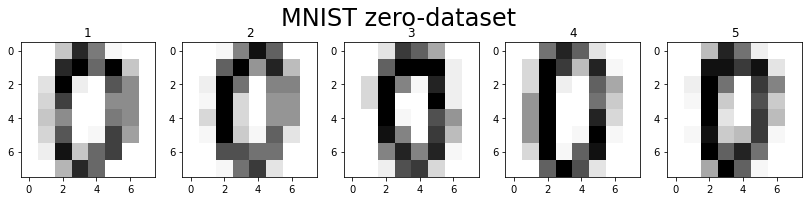

In [ ]:
# 「0」のみのデータセットを取得
zero_index_list = [i for i, x in enumerate(digits.target) if x == 0]
raw_data_list = [digits.data[i] for i in zero_index_list]

# 画像の表示
show_img(row=1, col=5, img_list1=raw_data_list, img_list2=None,
         title_list1=np.arange(1, 6), title_list2=None,
         subtitle="MNIST zero-dataset", subtitlesize=24, figsize=(14, 3))

次に、このデータセットをイジング変数{-1, +1}に変換します。

今回は閾値4として、4以上なら+1、4未満なら-1とします。また、データの数は50個とします。

In [ ]:
num_data = 50  # 使用するデータの数
num_spin = len(raw_data_list[0])  # 画像1枚のスピンの数

# データの加工
edit_data_list = []
for n in range(num_data):
    edit_data = [1 if raw_data_list[n][spin] >= 4 else -1 for spin in range(num_spin)]
    edit_data_list.append(edit_data)

加工前と加工後の画像を比較してみましょう。

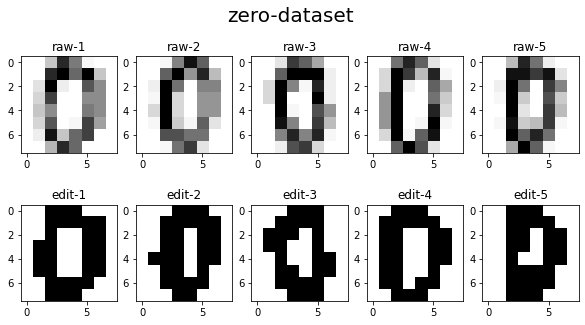

In [ ]:
raw_title = ['raw-' + str(num) for num in range(1, 6)]
edit_title = ['edit-' + str(num) for num in range(1, 6)]

show_img(row=2, col=5, img_list1=raw_data_list, img_list2=edit_data_list,
         title_list1=raw_title, title_list2=edit_title,
         subtitle="zero-dataset", subtitlesize=20, figsize=(10, 5))

上段が加工前、下段が加工後の画像に対応しています。これで、データセットの準備は終わりです。

### ボルツマン機械学習

ボルツマン機械学習の原理について説明します。

本論文では、量子相対エントロピー$S$が最小になることを目的としていました。

$$
S\left(\rho_{\mathscr{D}} \| \rho\right)=\operatorname{Tr} \rho_{\mathscr{D}} \ln \rho_{\mathscr{D}}-\operatorname{Tr} \rho_{\mathscr{D}} \ln \rho
$$

ここで、相互作用$J_{i,j}$, 局所磁場$h_i$における勾配法は、

$$
J_{i j}^{(k l)}(t+1)=J_{i j}^{(k l)}(t)+\eta \frac{\partial S}{\partial J_{i j}^{(k l)}}
$$

$$
\frac{1}{\beta} \frac{\partial S}{\partial J_{i j}^{(k l)}}=\left\langle\hat{Z}_{i}^{(k)} \hat{Z}_{j}^{(l)}\right\rangle_{\rho \mathcal{D}}-\left\langle\hat{Z}_{i}^{(k)} \hat{Z}_{j}^{(l)}\right\rangle_{\rho}
$$

$$
h_{i}^{(k)}(t+1)=h_{i}^{(k)}(t)+\eta \frac{\partial S}{\partial h_{i}^{(k)}}
$$

$$
\frac{1}{\beta} \frac{\partial S}{\partial h_{i}^{(k)}}=\left\langle\hat{Z}_{i}^{(k)}\right\rangle_{\rho \mathcal{D}}-\left\langle\hat{Z}_{i}^{(k)}\right\rangle_{\rho}
$$

で表せます。ここで、期待値$\left\langle{}\right\rangle_{\rho}$は、

$$
\left\langle\hat{Z}_{i}^{(k)} \hat{Z}_{j}^{(l)}\right\rangle_{\rho} =\frac{1}{L} \sum_{l=0}^{L} \hat{Z}_{i}^{(k)} \hat{Z}_{j}^{(l)}
$$

$$
\left\langle\hat{Z}_{i}^{(k)}\right\rangle_{\rho} =\frac{1}{L} \sum_{l=0}^{L} \hat{Z}_{i}^{(k)}
$$

のように求められます。

また、イジング変数$z_i$とすると、コスト関数は、

$$
E(\mathbf{z})=-\sum_{(i, j)} J_{i j} z_{i} z_{j}-\sum_{i} h_{i} z_{i}
$$

と表せます。

では、先ほど準備したデータセットの学習を行っていきましょう。

In [ ]:
from tqdm import tqdm

def minus_J(num_spin, J):
    m_J = {(i, j): J[(i, j)] * -1 for i in range(num_spin) for j in range(i+1, num_spin)}
    return m_J

def minus_h(num_spin, h):
    m_h = {i: h[i] * -1 for i in range(num_spin)}
    return m_h

def train_model(Tall, eta, dataset, sampler, sample_params, times):
    """ボルツマン機械学習

    Tall: 学習回数
    eta: 学習率
    dataset: データセット
    sampler: サンプラー
    sample_params: サンプリングの設定
    times: times回ごとにパラメータを保存する
    """
    J_dict = {}  # 学習済みの相互作用を格納する
    h_dict = {}  # 学習済みの局所磁場を格納する
    h = {i: 0 for i in range(num_spin)}  # 局所磁場の初期状態
    J = {(i, j): 0 for i in range(num_spin) for j in range(i+1, num_spin)}  # 相互作用の初期状態

    num_data=len(dataset) # データの数
    num_spin=len(dataset[0]) # スピンの数

    for t in tqdm(np.arange(Tall)):
        # OpenJijやD-Waveマシンには-1倍したh,Jを与える必要がある
        m_h = minus_h(num_spin, h)
        m_J = minus_J(num_spin, J)

        # サンプリング
        sampleset = sampler.sample_ising(h=m_h, J=m_J, **sample_params)
        x = sampleset.record.sample

        # 勾配法
        for i in range(num_spin):
            data_h_ave = np.average([dataset[k][i] for k in range(num_data)])  # データの経験平均
            sample_h_ave = np.average([x[k][i] for k in range(len(x))])  # サンプルの経験平均
            h[i] += eta * (data_h_ave - sample_h_ave)  # 局所磁場の更新
            for j in range(i+1, num_spin):
                data_J_ave = np.average([dataset[k][i] * dataset[k][j] for k in range(num_data)])  # データの経験平均
                sample_J_ave = np.average([x[k][i] * x[k][j] for k in range(len(x))])  # サンプルの経験平均
                J[(i, j)] += eta * (data_J_ave - sample_J_ave)  # 相互作用の更新

        # 一定の学習回数ごとにパラメータを保存
        if t == 0 or (t+1) % times == 0:
            J_dict[t+1] = J.copy()
            h_dict[t+1] = h.copy()

    return J_dict, h_dict

これで、学習の準備が終わりました。パラメータの学習を行いましょう。

In [ ]:
# Openjijの場合
import openjij as oj
from openjij import SQASampler
sampler = oj.SQASampler()

# D-Waveマシンの場合
# from dwave.system import DWaveSampler, EmbeddingComposite
# sampler_config = {'solver': 'DW_2000Q_6', 'token': 'YOUR_TOKEN'}
# sampler = EmbeddingComposite(DWaveSampler(**sampler_config))

本実験では30回の学習を行い、5回の学習毎にパラメータを保存します。

In [ ]:
J_dict, h_dict = train_model(Tall=30, eta=0.001, dataset=edit_data_list, 
                             sampler=sampler, sample_params={'beta': 1, 'num_reads': 100}, times=5)

100%|██████████| 30/30 [00:58<00:00,  1.95s/it]


これで、学習が終了しました。このパラメータを入力としてサンプリングを行い、結果を表示してみましょう。

### 画像の生成

学習済みのパラメータを使って、いくつかサンプリングしてみましょう。

In [ ]:
ans_list = []
for k in J_dict.keys():
    m_h = minus_h(num_spin, h_dict[k])
    m_J = minus_J(num_spin, J_dict[k])
    sampleset = sampler.sample_ising(h=m_h, J=m_J)
    ans_list.append(sampleset.record.sample)

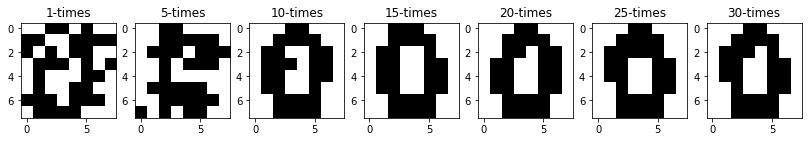

In [ ]:
times_title = [str(k) + '-times' for k in J_dict.keys()]
show_img(img_list1=ans_list, img_list2=None,
         title_list1=times_title, title_list2=None,
         subtitle="", subtitlesize=24, figsize=(14, 3))

学習回数を増やすにつれて、「0」のような画像を生成出来ていることが分かります。これより、手書き数字を学習出来ていることが確認できました。

### 画像の復元

ここでは、0-4の手書き数字を学習したパラメータを用いて画像の復元を行います。

まず、学習に使用する0-4の画像を用意しましょう。

In [ ]:
# 0-4のデータセットを抽出
zero_four_index_list = [i for i, x in enumerate(digits.target) if x <= 4]
raw_data04_list = [digits.data[i] for i in zero_four_index_lst]

# データの加工
num_data04 = len(raw_data04_list)
edit_data04_list = []
for n in range(num_data04):
    edit_data04 = [1 if raw_data04_list[n][spin] >= 4 else -1 for spin in range(num_spin)]
    edit_data04_list.append(edit_data04)

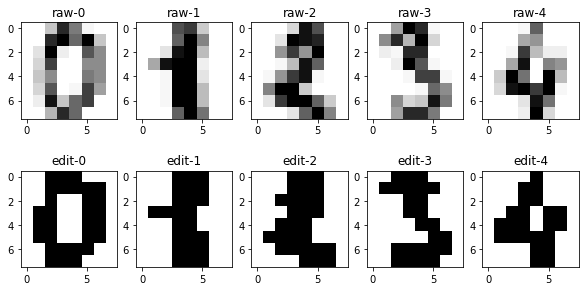

In [ ]:
# 学習に用いる画像の表示
raw_title = ['raw-' + str(num) for num in range(5)]
edit_title = ['edit-' + str(num) for num in range(5)]

show_img(row=2, col=5, img_list1=raw_data04_list, img_list2=edit_data04_list,
         title_list1=raw_title, title_list2=edit_title,
         subtitle="", subtitlesize=20, figsize=(10, 5))

次に、欠損のある画像を用意します。64ビットの画像に対して、半分の32ビットをランダムに選び0にしましょう。

In [ ]:
target_num = 3
loss_data = edit_data04_list[target_num].copy()

In [ ]:
import random

loss_spin_list = random.sample(list(np.arange(64)), 32)
for spin in loss_spin_list:
    loss_data[spin] = 0

ここで、元の画像と欠損した画像を比較してみましょう。

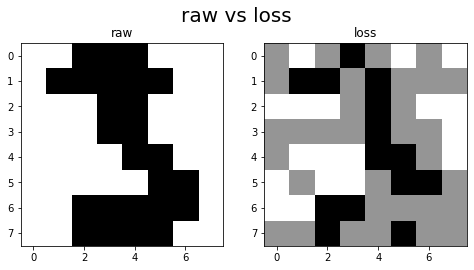

In [ ]:
vs_list = [edit_data04_list[target_num], loss_data]
show_img(row=1, col=2, img_list1=vs_list, img_list2=None,
         title_list1=['raw', 'loss'], title_list2=None,
         subtitle="raw vs loss", subtitlesize=20, figsize=(8, 4))

左が元の画像、右が欠損させた画像です。

ここからは、右の画像を復元していきましょう。復元する手順は以下の通りです。

1.   欠損がない箇所に局所磁場$h$を設定する
2.   この局所磁場$h$と学習済みの相互作用$J$を入力してサンプリングを行う

まず、欠損がない箇所に局所磁場を設定します。今回は、画素が1のとき$h=+1$、画素が-1のとき$h=-1$の磁場をかけます。

In [ ]:
loss_h = {s: loss_data[s] for s in range(num_spin)}

これで、局所磁場の設定は終わりです。

続いて、0-4の画像を学習した相互作用を生成します。

In [ ]:
J_loss_dict, h = train_model(Tall=30, eta=0.001, dataset=edit_data04_list,
                             sampler=sampler, sample_params={'beta': 1, 'num_reads': 100}, times=10)

100%|██████████| 30/30 [01:14<00:00,  2.49s/it]


最後に、局所磁場と学習済みの相互作用を入力して画像の復元を行います。

In [ ]:
result_list = vs_list.copy()
for k in J_loss_dict.keys():
    m_h = minus_h(num_spin, loss_h)
    m_J = minus_J(num_spin, J_loss_dict[k])
    sampleset = sampler.sample_ising(h=m_h, J=m_J, num_reads=100)
    result_list.append(list(sampleset.first.sample.values()))

結果を表示させてみましょう。

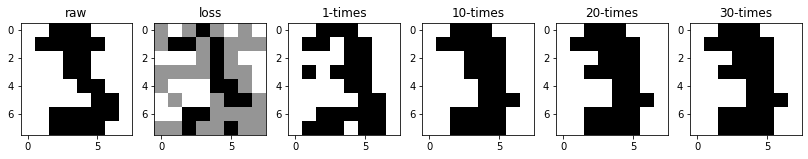

In [ ]:
times_title = ['raw', 'loss'] + [str(k) + '-times' for k in J_loss_dict.keys()]
show_img(row=1, col=2 + len(J_loss_dict), img_list1=result_list, img_list2='',
         title_list1=times_title, title_list2='',
         subtitle="", subtitlesize=24, figsize=(14, 3))

上手く復元することが出来ました。

## あとがき

本記事では、画像の生成および復元を行いました。論文では6000回学習を行っていますが、64ビットの手書き数字であれば30回程度の学習で十分だと分かりました。次の記事では、ランダムなイジング模型に対しても学習可能か検証します。

### 記事の担当者

鹿内怜央